In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from model import _build_model, _build_simple_model, _build_simple_model2
from model_reduced import _build_model, _build_simple_model, _build_simple_model2, _build_reduced_model, _build_reduced_model2
from core_eval_8kfb import Graph
import itertools
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

gpus = tf.config.experimental.list_logical_devices('GPU')
print(gpus)

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [22]:
# model =keras.models.load_model('reduced_modelxe_universal') 
# initialize env
# model =keras.models.load_model('/home/lab1/repo/planning/intergration/reduced_modelxIII_universal') 

# action_dict = list(itertools.product(np.round(np.arange(-0.2,0.21,0.01), decimals=2), \
#                                      np.round(np.arange(-5,6,1), decimals=0)))

model =keras.models.load_model('/home/lab1/repo/planning/intergration/reduced_modelxe_universal') 
action_dict = list(itertools.product(np.round(np.arange(-0.1,0.15,0.05), decimals=2), \
                                     np.round(np.arange(-3,4,1), decimals=0)))

In [27]:
env2=Graph()
timesteps = 10
state = env2.reset()
for timestep in range(timesteps):
    subject_tensor = tf.convert_to_tensor(state[0])
    subject_tensor = tf.expand_dims(subject_tensor, 0)

    veh_tensor = tf.convert_to_tensor(state[1])  
    veh_tensor = tf.expand_dims(veh_tensor, 0)

    ped_tensor = tf.convert_to_tensor(state[2])  
    ped_tensor = tf.expand_dims(ped_tensor, 0)

    cyc_tensor = tf.convert_to_tensor(state[3])  
    cyc_tensor = tf.expand_dims(cyc_tensor, 0)

    edge_tensor = tf.convert_to_tensor(state[4])   
    edge_tensor = tf.expand_dims(edge_tensor, 0) 

    # state_tensor = tf.expand_dims(state_tensor, 0)
    state_tensor = [subject_tensor, veh_tensor, ped_tensor, cyc_tensor, edge_tensor]
    action_probs = model(state_tensor, training=False)
    # Take best action
#     print(action_probs)
    print('--------------')
    action = tf.argmax(action_probs[0]).numpy()
    state_next, reward, done,_, hs, ms, dmin = env2.step(action)
   
    print(timestep, action, action_dict[action], reward,done, _,hs, ms, dmin)
    if done:
        break
    state = state_next
#     print(state)
    print("====================")
#     if timestep>2:break
print(env2.target.history)
print(hs)
print(ms)
print('dmin', dmin)

/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator BayesianGaussianMixture from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


--------------
0 16 (0.0, -1) 0.5452225226942413 False feasible 37.50811829457726 37.530195432589935 inf
--------------
1 16 (0.0, -1) 0.14208749698617806 False feasible 31.70896915700669 31.988340847069622 inf
--------------
2 16 (0.0, -1) 0.14809683987277542 False feasible 25.826190930913537 26.495253405491713 inf
--------------
3 16 (0.0, -1) 0.11717654496822102 False feasible 19.878845690834265 21.10288571479625 inf
--------------
4 16 (0.0, -1) 0.1604400218486472 False feasible 14.31455762501933 16.00396844345695 inf
--------------
5 16 (0.0, -1) 0.12409682755228421 False feasible 9.715989810616405 11.406902404073271 inf
--------------
6 16 (0.0, -1) 0.07275304509827642 False feasible 5.628654990315453 8.287577181728887 inf
--------------
7 16 (0.0, -1) 0.07592251758705997 False feasible 4.914079771432276 2.1629027562377208 inf
--------------
8 16 (0.0, -1) 0.07259992806206482 False feasible 3.8570165931714593 6.874404844670211 inf
--------------
9 16 (0.0, -1) 0.08360883402886211

In [28]:
sample = env2.sample
# print(sample)
target_obs = env2.target.traj[:10]
target_planned = np.array(env2.target.history)[:,1:3]
print(target_obs.shape, target_planned.shape)

(10, 2) (11, 2)


# visualization

In [5]:
import sys 
from ruixuan.turning_scene import *
from l5kit.rasterization.rasterizer_builder import _load_metadata
import time
import pickle
import math
from collections import deque

In [6]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/home/lab1/repo/planning/prediction-dataset"
# get config
cfg = load_config_data("/home/lab1/repo/planning/ruixuan/visualisation_config.yaml")
print(cfg)

dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()
print(zarr_dataset)

rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)

semantic_map_filepath = dm.require(cfg["raster_params"]["semantic_map_key"])
dataset_meta = _load_metadata(cfg["raster_params"]["dataset_meta_key"], dm)
world_to_ecef = np.array(dataset_meta["world_to_ecef"], dtype=np.float64)
Map_Api = MapAPI(semantic_map_filepath, world_to_ecef)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'future_num_frames': 50, 'step_time': 0.1}, 'raster_params': {'raster_size': [320, 320], 'pixel_size': [0.5, 0.5], 'ego_center': [0.6, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'val_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}}
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+------

In [7]:
class Trajectory(Scene):
    
    def __init__(self, dataset, Map_Api):
        super(Trajectory, self).__init__(dataset, Map_Api)
        self.label_name = ['Car','Van','Tram','Bus','Truck','EV','OV','Bicycle',\
                           'Motorcycle','Cyclist','Motorcyclist','Pedestrian']
        self.label_idx = list(range(3,15))
        self.label_dict = dict(zip(self.label_name, self.label_idx))
        self.all_traffic_control = None
        self.Traffic_Control = None

    def generate_info_from_MAP(self):
        self.all_junctions = self.get_elements("junction")
        self.all_lanes = self.get_elements("lane")
        self.all_traffic_control = self.get_elements("traffic_control_element")
        self.Lane = {self.map_api.id_as_str(lane.id):lane.element.lane for lane in self.all_lanes}
        self.Junction = {self.map_api.id_as_str(junction.id):junction for junction in self.all_junctions}
        self.Traffic_Control = {self.map_api.id_as_str(traffic_control.id):traffic_control.element for traffic_control in self.all_traffic_control}
        
        for junction in self.all_junctions:
            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = []

            for lane in junction.element.junction.lanes:
                self.Junction_Lane[self.map_api.id_as_str(junction.id)].append(self.map_api.id_as_str(lane))

            self.Junction_Lane[self.map_api.id_as_str(junction.id)] = set(self.Junction_Lane[self.map_api.id_as_str(junction.id)])
        
        self.junction_scene = dict.fromkeys(list(self.Junction.keys()), [])
        self.junction_turning_scene = dict.fromkeys(list(self.Junction.keys()), {})
        for key in self.Junction.keys():
            self.junction_turning_scene[key] = {'Turning Left': [], 'Turning Right': []}    
        
        
    def label_loc_check(self, target_label):
    
        agent_id_list = self.agent_list[self.label_dict[target_label]-3]

        for agent_id in agent_id_list:
            agent_loc = self.agent_centroid[np.where(self.agent_id==agent_id)[0]]
            for centroid in agent_loc:
                if self.Junction_region.contains(Point(centroid[0],centroid[1])):
                    return True
    
    def junction_lane_visualize(self, junction_id):
        
        plt.figure(figsize=(18,18))
        
        lane_list = self.Junction_Lane[junction_id]
        
        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,0].tolist(),
                        self.map_api.get_lane_coords(lane)['xyz_left'][:,1].tolist()+ self.map_api.get_lane_coords(lane)['xyz_right'][:,1].tolist(),
                        marker='x', label = lane)

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20)
        axes = plt.gca()  
    
                
    def agent_trajectory(self, scene, target_label, junction_boundary):

        self.scene = scene
        self.target_label = target_label
#         self.junction = junction
        # region for junction "sGK1"
#         junction_boundary = {junction:[(300,-1150),[300,-1100],(340,-1100),(340,-1150)]}

        # region for junction "8KfB"
#         junction_boundary = {junction:[(500,-2420),(500,-2360),(560,-2360),(560,-2420)]}
        
        # region for lane merge
#         junction_boundary = {junction:[(-940,1380),(-940,1480),(-880,1380),(-880,1480)]}

        self.Junction_region = Polygon(junction_boundary)

        self.agent_list = []
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        agent_interval_begin = self.dataset.frames[frame_interval[0]]['agent_index_interval'][0]
        agent_interval_end = self.dataset.frames[frame_interval[1]-1]['agent_index_interval'][1]
        self.agent_id = self.dataset.agents[agent_interval_begin:agent_interval_end]['track_id']
        agent_label_prob = self.dataset.agents[agent_interval_begin:agent_interval_end]['label_probabilities']
        self.agent_centroid = self.dataset.agents[agent_interval_begin:agent_interval_end]['centroid']

        for label in self.label_idx:
            valid_idx = np.where(agent_label_prob[:,label]>0.5)[0]
            valid_id = set(self.agent_id[valid_idx])
            self.agent_list.append(list(valid_id))

        if len(self.agent_list[self.label_dict[target_label]-3])>0 and self.label_loc_check(target_label):
            return [scene]
        else:
            # print('Not feasible scene')
            return []
        
    def get_agent_traj(self, scene, target_label, junction, lane_list):
        veh_traj, ped_traj, cyclist_traj=[], [], [] 
        print(self.label_dict, self.label_dict[target_label])
        for idx, agent_label in enumerate(self.agent_list):
            print("xxx", idx, agent_label)
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 200  \
                and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    veh_traj.append(agent_loc)
#                     plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '\
#                              +self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3 and agent_loc.shape[0] > 100:
                    ped_traj.append(agent_loc)
        veh_traj, ped_traj, cyclist_traj = np.array(veh_traj), np.array(ped_traj), np.array(cyclist_traj)
        return veh_traj, ped_traj,cyclist_traj
#                     plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')
            
            
            
    def trajectory_junction_visualize(self, scene, target_label, junction, lane_list):
        
        frame_interval = self.dataset.scenes[scene]['frame_index_interval']
        
        plt.figure(figsize=(18,18))

        for lane in lane_list:
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_right'][:,0], self.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='k',linewidth=5, alpha=0.2)
            plt.plot(self.map_api.get_lane_coords(lane)['xyz_left'][:,0], self.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                     color='k',linewidth=5, alpha=0.2)

        cmap = plt.get_cmap('gnuplot')    
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
         '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','maple','yellowgreen'] 

        for idx, agent_label in enumerate(self.agent_list):
            for agent in agent_label:
                agent_loc = self.agent_centroid[np.where(self.agent_id==agent)[0]]
                if idx != self.label_dict[target_label]-3 and agent_loc.shape[0] > 100  and np.linalg.norm(agent_loc[0,:]-agent_loc[-1,:]) > 5:
                    plt.plot(agent_loc[:,0],agent_loc[:,1],label='Agent ID '+str(agent)+': '+self.label_name[idx], color=colors[idx])

                elif idx== self.label_dict[target_label]-3 and  agent_loc.shape[0] > 100:
                    plt.plot(agent_loc[:,0],agent_loc[:,1], color=colors[idx], marker='*')

        ego_translation = self.frames[frame_interval[0]:frame_interval[1]]['ego_translation']
        plt.plot(ego_translation[:,0],ego_translation[:,1],label='Ego',color='r')
        turn = ' Left Turn' if rotation33_as_yaw(self.frames[frame_interval[0]]['ego_rotation']) - rotation33_as_yaw(self.frames[frame_interval[1]-1]['ego_rotation']) < 0 else ' Right Turn'

        plt.axis("equal")
        plt.grid(which='both')
        plt.legend(fontsize=20,loc='best')
        plt.title('Trajectory : Scene '+str(scene)+turn+' at Junction '+junction, fontsize=30)
        axes = plt.gca()


In [8]:
junction_lane_merge = np.load('ruixuan/target_scene_index/lane_merge/scene_index(lane_merge)_Pedestrian.npy',allow_pickle = True)
junction_8KfB = np.load('ruixuan/target_scene_index/8KfB/scene_index(8KfB)_Pedestrian.npy',allow_pickle = True)

In [9]:
lane_list = {}
junction_boundary = {}
# extend lane sequences
lane_list['lane_merge'] = ['ADrl',"oFEC",'m0JU','iQgg','M5V5','/Pgg','FFEC','XHTU']
lane_list['8KfB'] = ['/24B','6p63','FV1O','MV/U','SxVb','TG2b','TZZv','ZnUV','bH1o','dddQ','nXc0','zHjP','SD8o','vC8o']
junction_boundary['lane_merge'] = [(-940,1380),(-940,1480),(-880,1380),(-880,1480)]
junction_boundary['8KfB'] = [(500,-2420),(500,-2360),(560,-2360),(560,-2420)]
# junction_boundary['8KfB'] = [(450,-2400),(500,-2360),(560,-2360),(560,-2420)]
grid_boundary={}
grid_boundary['lane_merge']={'X':[-990, -850], 'Y':[1390, 1490]}
grid_boundary['8KfB']={'X':[450,600], 'Y':[-2450, -2300]}

In [10]:
Test = Trajectory(zarr_dataset, Map_Api)
Test.generate_info_from_MAP()

In [11]:
def get_grid(intersection_id,grid_boundary):
    x = grid_boundary[intersection_id]['X']
    y = grid_boundary[intersection_id]['Y']
    x_ = np.linspace(x[0], x[1],150)
    y_ = np.linspace(y[0], y[1],150)
    x_mesh, y_mesh = np.meshgrid(x_, y_)
    return x_mesh, y_mesh

def locate_in_mesh(x_mesh, y_mesh, point):
    x, y = point[0], point[1]
    result=[]
#     print(x, y, x_mesh[0], x_mesh[-1], y_mesh[0], y_mesh[-1])
    if x>x_mesh[-1] or x<x_mesh[0] or y>y_mesh[-1] or y<y_mesh[0]:
        return None
    result = [math.floor(x-x_mesh[0]), math.floor(y-y_mesh[0])]
    return result

def plot_scene_on_grid(intersection_id, lane_list, grid_boundary, veh=None, ped=None, cyc=None):
    """
    plt agent trajectories in the grid map for a scene
    """
    plt.figure(figsize=(18,18))
    plt.xlim(grid_boundary[intersection_id]['X'][0],grid_boundary[intersection_id]['X'][1])
    plt.ylim(grid_boundary[intersection_id]['Y'][0],grid_boundary[intersection_id]['Y'][1])
    for lane in lane_list[intersection_id]:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='g',linewidth=1,label=lane)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='g',linewidth=1)
#         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
    x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
#     print(x_mesh.shape, y_mesh[:,1])
    plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
    plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
#     plt.title(intersection_id,fontsize=30)

    if veh is not None:
        for traj in veh: plt.plot(traj[:,0],traj[:,1], c='b',linewidth=0.5)
    if ped is not None:
        for traj in ped: plt.scatter(traj[:,0],traj[:,1], c='orange',linewidth=0.5)
    if cyc is not None:
        for traj in cyc: plt.plot(traj[:,0],traj[:,1], c='cyan',linewidth=0.5)
    plt.axis('off')
    plt.show()
    
def plot_planned_on_grid(intersection_id, lane_list, grid_boundary, veh=None, ped=None, cyc=None,\
                        target_obs=None, planned=None, other_planned=None):
    """
    plt agent trajectories in the grid map for a scene
    """
    plt.figure(figsize=(18,18))
    plt.xlim(grid_boundary[intersection_id]['X'][0],grid_boundary[intersection_id]['X'][1])
    plt.ylim(grid_boundary[intersection_id]['Y'][0],grid_boundary[intersection_id]['Y'][1])
    for lane in lane_list[intersection_id]:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='g',linewidth=1,label=lane)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='g',linewidth=1)
#         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
    x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
#     print(x_mesh.shape, y_mesh[:,1])
    plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
    plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
#     plt.title(intersection_id,fontsize=30)

    if veh is not None:
        for traj in veh: plt.plot(traj[:,0],traj[:,1], c='b',linewidth=0.5)
    if ped is not None:
        for traj in ped: plt.scatter(traj[:,0],traj[:,1], c='orange',linewidth=0.5)
    if cyc is not None:
        for traj in cyc: plt.plot(traj[:,0],traj[:,1], c='cyan',linewidth=0.5)
    if target_obs is not None:
        plt.plot(target_obs[:,0],target_obs[:,1], c='green',linewidth=1)
    if planned is not None:
        plt.plot(planned[:,0],planned[:,1], c='red',linewidth=1)
    if other_planned is not None:
        plt.plot(planned[:,0],planned[:,1], c='pink',linewidth=1)
    plt.axis('off')
    plt.show()
    

In [12]:
def animate_planned_on_grid(intersection_id, lane_list, grid_boundary, veh=None, ped=None,\
                            cyc=None, target_obs=None, planned=None):
    """
    plt agent trajectories in the grid map for a scene
    """
    for idx in range(20):
        plt.figure(figsize=(18,18),frameon=False)
        plt.xlim(grid_boundary[intersection_id]['X'][0],grid_boundary[intersection_id]['X'][1])
        plt.ylim(grid_boundary[intersection_id]['Y'][0],grid_boundary[intersection_id]['Y'][1])
        for lane in lane_list[intersection_id]:
            plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                     color='g',linewidth=1,label=lane)
            plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                     color='g',linewidth=1)
    #         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
        x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
    #     print(x_mesh.shape, y_mesh[:,1])
        plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
        plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
    #     plt.title(intersection_id,fontsize=30)

    
        if veh is not None:
            for traj in veh: 
                plt.plot(traj[:idx,0],traj[:idx,1], c='b',linewidth=1)
        if ped is not None:
            for traj in ped: 
                plt.plot(traj[:idx,0],traj[:idx,1], c='orange',linewidth=1)
        if cyc is not None:
            for traj in cyc: 
                plt.plot(traj[:idx,0],traj[:idx,1], c='cyan',linewidth=1)
                
        if target_obs is not None and planned is not None:
            if idx<10:
                plt.plot(target_obs[:idx,0],target_obs[:idx,1], c='green',linewidth=1)
            else:
                plt.plot(target_obs[:10,0],target_obs[:10,1], c='green',linewidth=1)
                plt.plot(planned[:idx-9,0],planned[:idx-9,1], c='red',linewidth=2)

        plt.axis('off')
        plt.ioff()
#         plt.savefig("animation_fig/%s.png" %(str(idx)),  bbox_inches='tight',pad_inches = 0)
        plt.show()

In [13]:

    
def get_aseq(traj):
    aseq=[]
    vseq=[]
    for i in range(9,len(traj)-1):
        curr = traj[i+1]
        prev = traj[i]
        prev2= traj[i-1]
        v10 = np.linalg.norm(curr - prev)/0.5
        v9 = np.linalg.norm(prev - prev2)/0.5
        a = (v10-v9)/0.5
        aseq.append(a)
        vseq.append((v10+v9)/2)
    return aseq, vseq
    
def get_jerkness(traj):
    """
    compute the jerkness of the trajectory of 20 points
    """
   
    history_a,history_v = get_aseq(traj)
    jerk=[]
    for i in range(1,len(history_a)):
        jerk.append(abs((history_a[i]-history_a[i-1])/0.5))
    return jerk

def get_energy_consumption(vseq, aseq):
    # ref: https://www.sciencedirect.com/science/article/pii/S1361920915301280?casa_token=8cxvEOX36HEAAAAA:pb0MizZnGEW4ZMZKnRPgURXOsd6COFG_IuWO-8oVWkXSLcY3D0t9oFXuRogrHWTsnW_jFKgYtw
    E=[]
    accumulated_e=[0]
    for t in range(len(vseq)):
        v, a=vseq[t], aseq[t]
        if a<=0:
            accumulated_e.append(accumulated_e[-1])
            continue # break, no energy consumed
        #ford
        p = 1110*v-96.61*(v**2)+2.745*(v**3) + 1439*v*a
        E.append(p*0.5)
        accumulated_e.append(accumulated_e[-1] + p*0.5)
#         E.append(accumulated_e)
    return accumulated_e

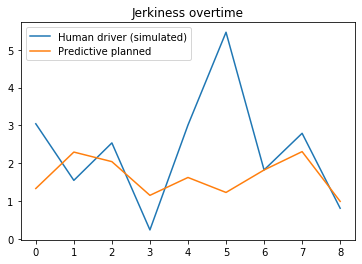

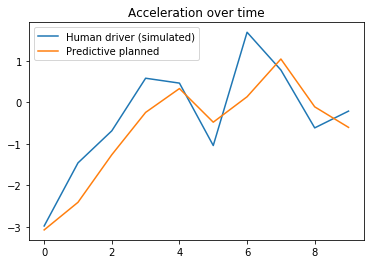

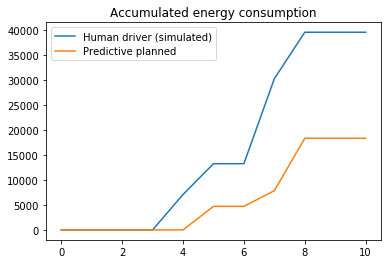

Total energy consumed for human/model 182821.31797923218 72421.95450085182


In [29]:
jerk_human = get_jerkness(env2.target.traj)
# print("jerk_human",jerk_human)
jerk_planned = get_jerkness(np.vstack((target_obs, target_planned[1:])))
# print("jerk_planned",jerk_planned)
x = np.arange(len(jerk_human))
plt.title('Jerkiness overtime')
plt.plot(np.arange(len(jerk_human)), jerk_human, label='Human driver (simulated)')
plt.plot(np.arange(len(jerk_planned)), jerk_planned, label= "Predictive planned")
plt.legend()
# plt.savefig('result_fig/jerk')
plt.show()


acc_human, v_human = get_aseq(env2.target.traj)
acc_planned, v_planned = get_aseq(np.vstack((target_obs, target_planned[1:])))
# print("acc_human", acc_human)
# print("v_human", v_human)
# print("acc_planned", acc_planned)
# print("v_planned", v_planned)
x = np.arange(len(acc_human))
plt.title("Acceleration over time")
plt.plot(np.arange(len(acc_human)), acc_human, label='Human driver (simulated)')
plt.plot(np.arange(len(acc_planned)), acc_planned, label= "Predictive planned")
plt.legend()
# plt.savefig('result_fig/acc')
plt.show()

e_human  = get_energy_consumption(v_human, acc_human)
e_planned = get_energy_consumption(v_planned, acc_planned)
# print("e_human", e_human)
# print("e_planned", e_planned)
# print("energy consumption by human/planned",e_human, e_planned)
plt.plot(np.arange(len(e_planned)),e_human ,label='Human driver (simulated)')
plt.plot(np.arange(len(e_planned)),e_planned, label= "Predictive planned" )
plt.legend()
plt.title("Accumulated energy consumption")
plt.show()
print('Total energy consumed for human/model', sum(e_human), sum(e_planned))

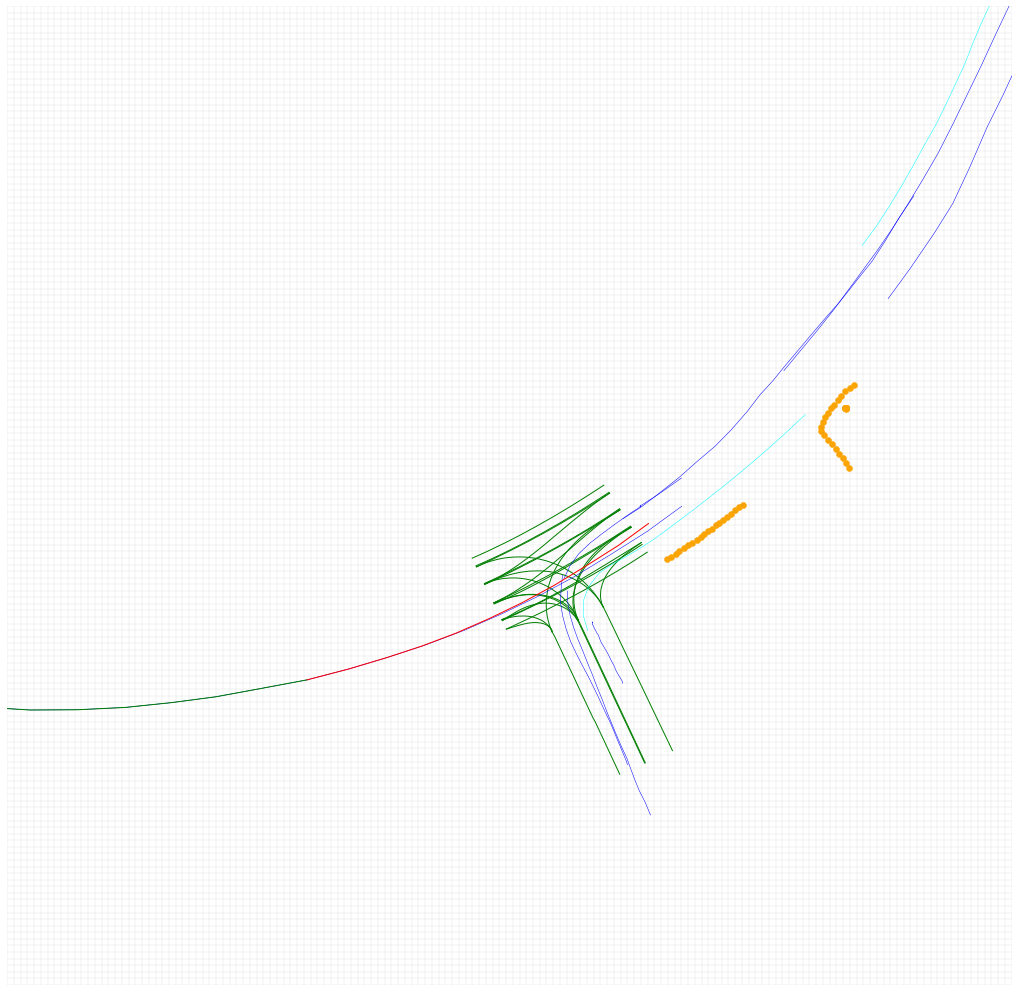

In [30]:
plot_planned_on_grid('8KfB', lane_list=lane_list, \
                           grid_boundary=grid_boundary, veh=sample['veh'][:], ped=sample['ped'], cyc=sample['cyc'],
                    target_obs=target_obs, planned=target_planned, other_planned=None)

In [31]:
# pickle.dump(sample, open("some_scenes/collision_with_ped_scene", 'wb'))
# pickle.dump(target_obs, open("some_scenes/collision_with_ped_target_obs", 'wb'))
# pickle.dump(target_planned, open("some_scenes/collision_with_ped_target_planned", 'wb'))

# investigate group behavior

In [32]:
env2=Graph()
num_scenes =1000
hjerkiness_all=[]
hacceleration_all=[]
henergy_all =[]
mjerkiness_all=[]
macceleration_all=[]
menergy_all =[]

hs_all=[]
ms_all=[]
total_time=[]
nscenes=0
dmin=[]

while nscenes < num_scenes:
    if nscenes%100==0: print(nscenes, "out of", num_scenes)
    
    timesteps = 10
    state = env2.reset()
    tt=0
    series_hs, series_ms=[],[]
    for timestep in range(timesteps):
        tt+=1
        subject_tensor = tf.convert_to_tensor(state[0])
        subject_tensor = tf.expand_dims(subject_tensor, 0)

        veh_tensor = tf.convert_to_tensor(state[1])  
        veh_tensor = tf.expand_dims(veh_tensor, 0)

        ped_tensor = tf.convert_to_tensor(state[2])  
        ped_tensor = tf.expand_dims(ped_tensor, 0)

        cyc_tensor = tf.convert_to_tensor(state[3])  
        cyc_tensor = tf.expand_dims(cyc_tensor, 0)

        edge_tensor = tf.convert_to_tensor(state[4])   
        edge_tensor = tf.expand_dims(edge_tensor, 0) 

        # state_tensor = tf.expand_dims(state_tensor, 0)
        state_tensor = [subject_tensor, veh_tensor, ped_tensor, cyc_tensor, edge_tensor]
        action_probs = model(state_tensor, training=False)
        # Take best action
    #     print(action_probs)
#         print('--------------')
        action = tf.argmax(action_probs[0]).numpy()
        state_next, reward, done,_, hs, ms, d_min = env2.step(action)
        series_hs.append(hs)
        series_ms.append(ms)
#         print(timestep, action, action_dict[action], reward,done, _)
        if done:
#             print("stressor",hs, ms)
            break
        state = state_next
    #     print(state)
#         print("====================")
    #     if timestep>2:break
#     print(env2.target.history)
#     print(tt)
    if tt<10: 
        del series_hs[-1]
        del series_ms[-1]
        continue # too short, not the kind of task we want to investigate
    nscenes+=1
    total_time.append(tt) # time for planning, human is always 5s 
#     print(hs)
#     print(ms)
    dmin.append(d_min)
    hs_all.append(series_hs)
    ms_all.append(series_ms)
    
    sample = env2.sample
    # print(sample)
    target_obs = env2.target.traj[:10]
    target_planned = np.array(env2.target.history)[:,1:3]
    
    jerk_human = get_jerkness(env2.target.traj)
    jerk_planned = get_jerkness(np.vstack((target_obs, target_planned[1:])))
    
    hjerkiness_all.append(jerk_human)
    mjerkiness_all.append(jerk_planned)
    
    acc_human, v_human = get_aseq(env2.target.traj)
    acc_planned, v_planned = get_aseq(np.vstack((target_obs, target_planned[1:])))
    
    hacceleration_all.append(acc_human)
    macceleration_all.append(acc_planned)
    
    e_human  = get_energy_consumption(v_human, acc_human)
    e_planned = get_energy_consumption(v_planned, acc_planned)
    
    henergy_all.append(e_human)
    menergy_all.append(e_planned)
print("Done")

    

/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator BayesianGaussianMixture from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


0 out of 1000
100 out of 1000
100 out of 1000
100 out of 1000
200 out of 1000
300 out of 1000
400 out of 1000
500 out of 1000
600 out of 1000
700 out of 1000
800 out of 1000
900 out of 1000
900 out of 1000
Done


In [33]:
hs_ele=[]
ms_ele=[]

for s in hs_all:
    hs_ele.append(np.min(s))
for s in ms_all:
    ms_ele.append(np.min(s))

print(sum(hs_ele)/len(hs_ele), sum(ms_ele)/len(ms_ele), sum(dmin)/len(dmin))

8.696117327277323 8.901592253556856 8.696117327277323


In [34]:
ms3=0
ds3=0
print(max(dmin), max(ms_ele))
for ele in ms_ele:
    if ele<3:
        ms3+=1
for ele in hs_ele:
    if ele <3:
        ds3+=1
print(ms3, ds3)

107.0712224876506 111.03076744758987
220 227


In [35]:
print(dmin[:10])
print(hs_ele[:10])
print(ms_ele[:10])

[32.41108052811548, 3.473767119425417, 3.5461957080792517, 2.3887042512623955, 2.660803638000934, 43.09340994862208, 5.3677863221254345, 3.102327674504863, 4.83259102345743, 3.9553949233924963]
[32.41108052811548, 3.473767119425417, 3.5461957080792517, 2.3887042512623955, 2.660803638000934, 43.09340994862208, 5.3677863221254345, 3.102327674504863, 4.83259102345743, 3.9553949233924963]
[32.869210173204685, 3.6034789304444117, 3.2867017119977726, 1.7435088357166917, 2.640063385123822, 43.0203783012562, 5.322742343639155, 3.4953390324970335, 4.808957287908277, 4.152535260143802]


In [36]:
import scipy
print(len(ms_ele), np.std(hs_ele), np.std(ms_ele))
ttest_score = scipy.stats.ttest_rel(hs_ele, ms_ele)
print(ttest_score)
print(sum(hs_ele)/len(hs_ele), sum(ms_ele)/len(ms_ele))

1000 13.70518490470767 13.967415073898508
Ttest_relResult(statistic=-6.267034709794029, pvalue=5.463867126026724e-10)
8.696117327277323 8.901592253556856


In [37]:
def fill_array(arr, length=11, catagory='energy'):
    res=[]
    if catagory=='energy':
        for ele in arr:
            if len(ele)<1:continue
            if len(ele)<length: # energy
    #             print(len(ele), ele)
                ele = ele + [ele[-1]]*(length-len(ele))
            res.append(ele)
    else:
        for ele in arr:
            if len(ele)<1:continue
            if len(ele)<length: # energy
    #             print(len(ele), ele)
                ele = ele + [0]*(length-len(ele))
            res.append(ele)
    return np.array(res)

henergy_all= np.array(henergy_all)
menergy_all = fill_array(menergy_all)
# menergy_all=np.array(menergy_all)

hjerkiness_all = np.array(hjerkiness_all)
hacceleration_all = np.array(hacceleration_all)



In [38]:

macceleration_all = fill_array(macceleration_all, 10, 'acceleration')
mjerkiness_all = fill_array(mjerkiness_all,9, 'jerkiness')
print(menergy_all.shape, macceleration_all.shape, mjerkiness_all.shape)

(1000, 11) (1000, 10) (1000, 9)


In [39]:
print(hjerkiness_all.shape, mjerkiness_all.shape)
ttest_score_j = scipy.stats.ttest_rel(hjerkiness_all[:,-1], mjerkiness_all[:,-1])
print(sum(hjerkiness_all[:,-1])/len(hjerkiness_all[:,-1]), sum(mjerkiness_all[:,-1])/len(mjerkiness_all[:,-1]))
print(ttest_score_j)
print("=======")
ttest_score_j2 = scipy.stats.ttest_rel(np.mean(hjerkiness_all, axis=0), np.mean(mjerkiness_all, axis=0))
print(np.mean(hjerkiness_all), np.mean(mjerkiness_all))

print(ttest_score_j2)

(1000, 9) (1000, 9)
3.9301427165501375 1.783324533571954
Ttest_relResult(statistic=16.18704023228091, pvalue=1.6364088674224014e-52)
3.4674133702919296 1.613890929645361
Ttest_relResult(statistic=18.154972396515515, pvalue=8.704648918105554e-08)


In [40]:
print(henergy_all.shape, menergy_all.shape)
ttest_score_j = scipy.stats.ttest_rel(henergy_all[:,-1], menergy_all[:,-1])
print(sum(henergy_all[:,-1])/len(henergy_all[:,-1]), sum(menergy_all[:,-1])/len(menergy_all[:,-1]))
print(ttest_score_j)

(1000, 11) (1000, 11)
44075.608689123976 25538.35829348576
Ttest_relResult(statistic=33.913220753431034, pvalue=2.277979382715233e-168)


In [41]:
henergy_per_timestep=np.sum(henergy_all[:,-1])/(len(menergy_all)*10)
menergy_per_timestep=np.sum(menergy_all[:,-1])/sum(total_time)
print("Average human/mode energy consumption per timestep (0.5s): " ,henergy_per_timestep, menergy_per_timestep)

Average human/mode energy consumption per timestep (0.5s):  4407.5608689124 2553.8358293485753


(1000, 11) (1000, 10) (1000, 9)


<Figure size 720x576 with 0 Axes>

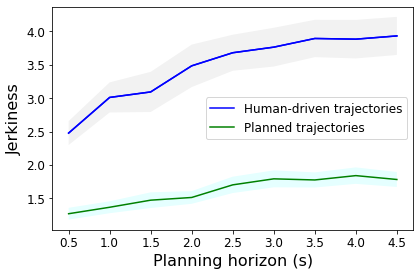

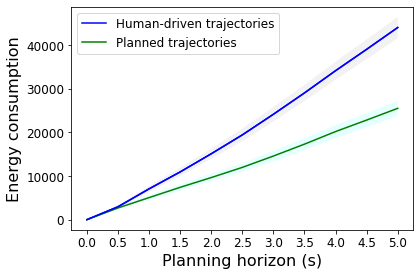

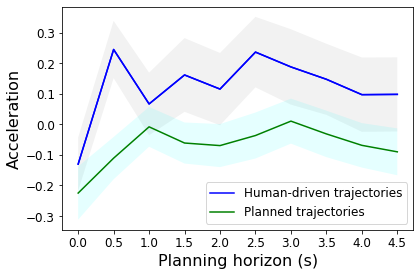

In [45]:
import scipy.stats
import matplotlib.pyplot as plt 
fig=plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 12})
def mean_confidence_interval(data, confidence=0.95):
    a = np.array(data)
#     print(a.shape)
    n = len(a)
    m, se = np.mean(a,axis=0), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def conf_plot(arr1, arr2, timerange, catagory = 'Jerkiness', savefig=None, filename = 'jerkiness'):
    low, high, mean = [],[],[]
    m_low, m_high, m_mean = [], [],[]
    for j in range(timerange):
        m,l,h=mean_confidence_interval(arr1[:,j])
        low.append(l)
        high.append(h)
        mean.append(m)

        m,l,h=mean_confidence_interval(arr2[:,j])
        m_low.append(l)
        m_high.append(h)
        m_mean.append(m)
        
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    
    
    
    x = np.arange(0,(timerange)*0.5,0.5)
    ax1.fill_between(x, low, high,facecolor='gray',alpha=0.1)
    plt.plot(x, mean,c='blue', label='Human-driven trajectories')

    ax1.fill_between(x, m_low, m_high,facecolor='cyan',alpha=0.1)
    
    if catagory =='Jerkiness':
        plt.xticks(np.arange(0,(timerange)*0.5,0.5), np.arange(0.5,(timerange)*0.5+0.5,0.5))
        
    else:
        plt.xticks(np.arange(0,(timerange)*0.5,0.5))
#     plt.xticks(np.arange(0,(timerange)*0.5,0.5))

    plt.plot(x, m_mean,c='green', label='Planned trajectories')

    ax1.set_ylabel(catagory,fontsize=16)
    ax1.set_xlabel('Planning horizon (s)', fontsize=16)

    plt.plot(x, mean,c='blue')
    plt.legend()
#     plt.legend(loc= 'upper left')
    plt.tight_layout()
    pth = 'paper/'+filename
    plt.savefig(pth,dpi=100)
    plt.show()


    
#     return low, high, mean, m_low, m_high, m_mean
print(menergy_all.shape, macceleration_all.shape, mjerkiness_all.shape)
conf_plot(hjerkiness_all, mjerkiness_all, 9)
conf_plot(henergy_all, menergy_all, 11, 'Energy consumption', filename='energy')
conf_plot(hacceleration_all, macceleration_all, 10, 'Acceleration', filename='acceleration')

# fig, ax1 = plt.subplots(1, 1, sharex=True)
# x = np.arange(0.5,5,0.5)
# print(len(x))
# ax1.fill_between(x, low, high,facecolor='gray',alpha=0.3)
# # plt.xticks(np.arange(0.5, 5.5, step=0.5))
# # ax1.set_ylabel('Jerkiness',fontsize=14)
# # ax1.set_xlabel('Planning time', fontsize=14)

# plt.plot(x, mean,c='blue', label='Human driver')

# ax1.fill_between(x, m_low, m_high,facecolor='gray',alpha=0.3)
# plt.xticks(np.arange(0.5, 5.5, step=0.5))

# plt.plot(x, m_mean,c='green', label='Planned')


# ax1.set_ylabel('Jerkiness',fontsize=14)
# ax1.set_xlabel('Planning time', fontsize=14)

# plt.plot(x, mean,c='blue')
# plt.legend()
# # plt.savefig("ade_wconf.png",dpi=100)
# plt.show()

# visualize action space

In [15]:
def _get_av2( prev2, prev, curr):
    v10 = np.linalg.norm(curr - prev)/0.5
    v9 = np.linalg.norm(prev - prev2)/0.5
    a = (v10-v9)/0.5
    return a, (v10+v9)/2
    
def _get_theta2(prev,curr):
    diff_x = curr[0]-prev[0] 
    diff_y = curr[1]-prev[1]

    if diff_x>0 and diff_y>0:
        indicator=1
    elif diff_x<=0 and diff_y>=0:
        indicator=2
    elif diff_x<=0 and diff_y<=0:
        indicator = 3
    else:
        indicator=4
    try:
        if diff_x !=0:
            tan = diff_y/diff_x
            # print("tan", tan, math.atan(tan)*180/math.pi)
            return math.atan(tan)*180/math.pi, indicator
        else:
            return 90, indicator
    except:
        return 90, indicator
    
        
        
def _get_guide(traj):
    guide=[]
    for i in range(9,19):
        a,_ = _get_av2(traj[i-1], traj[i], traj[i+1])
        theta, indicator = _get_theta2(traj[i], traj[i+1])
        guide.append([a, theta, indicator])
    return guide
    

def max_move(traj, guide, unit=5):
    # [0.1, -3] [0.1, 3]
    traj_max=[]
    v1 =  np.linalg.norm(traj[10] - traj[9])/0.5
    v2 = np.linalg.norm(traj[9] - traj[8])/0.5
    v = (v1+v2)/2
    pos = traj[9]
    for t in range(10):
        traj_max.append(pos)
        guide_a, guide_theta, guide_indicator  = guide[t]

        a = guide_a+0.2
        theta=guide_theta+unit # 5 is the max


        distance = v*0.5+0.5*a*0.25
        radian = theta*math.pi/180
        dx, dy = abs(distance*math.cos(radian)), abs(distance*math.sin(radian))
        #update state
        if guide_indicator==1: # zone 1
            pos =[pos[0]+dx, pos[1]+dy]
        elif guide_indicator==2:
            pos =[pos[0]-dx, pos[1]+dy]
        elif guide_indicator==3:
            pos =[pos[0]-dx, pos[1]-dy]
        else:
            pos =[pos[0]+dx, pos[1]-dy]


        v = v+a*0.5
    traj_max.append(pos)
    return np.array(traj_max)

def min_move(traj, guide, unit=-5):
    # [0.1, -3] [0.1, 3]
    traj_min=[]
    v1 =  np.linalg.norm(traj[10] - traj[9])/0.5
    v2 = np.linalg.norm(traj[9] - traj[8])/0.5
    v = (v1+v2)/2
    pos = traj[9]
    for t in range(10):
        traj_min.append(pos)
        guide_a, guide_theta, guide_indicator  = guide[t]

        a = guide_a-0.2
        theta=guide_theta+unit


        distance = v*0.5+0.5*a*0.25
        radian = theta*math.pi/180
        dx, dy = abs(distance*math.cos(radian)), abs(distance*math.sin(radian))
        #update state
        if guide_indicator==1: # zone 1
            pos =[pos[0]+dx, pos[1]+dy]
        elif guide_indicator==2:
            pos =[pos[0]-dx, pos[1]+dy]
        elif guide_indicator==3:
            pos =[pos[0]-dx, pos[1]-dy]
        else:
            pos =[pos[0]+dx, pos[1]-dy]


        v = v+a*0.5
    traj_min.append(pos)
    return np.array(traj_min)

def show_move(traj, guide, unit_a = -0.2, unit=-5):
    # [0.1, -3] [0.1, 3]
    traj_min=[]
    v1 =  np.linalg.norm(traj[10] - traj[9])/0.5
    v2 = np.linalg.norm(traj[9] - traj[8])/0.5
    v = (v1+v2)/2
    pos = traj[9]
    for t in range(10):
        traj_min.append(pos)
        guide_a, guide_theta, guide_indicator  = guide[t]

        a = guide_a+unit_a
        theta=guide_theta+unit


        distance = v*0.5+0.5*a*0.25
        radian = theta*math.pi/180
        dx, dy = abs(distance*math.cos(radian)), abs(distance*math.sin(radian))
        #update state
        if guide_indicator==1: # zone 1
            pos =[pos[0]+dx, pos[1]+dy]
        elif guide_indicator==2:
            pos =[pos[0]-dx, pos[1]+dy]
        elif guide_indicator==3:
            pos =[pos[0]-dx, pos[1]-dy]
        else:
            pos =[pos[0]+dx, pos[1]-dy]


        v = v+a*0.5
    traj_min.append(pos)
    return np.array(traj_min)

def action_move(traj, guide, unit =5):
    traj_min=[]
    
    for t in range(10):
        v1 =  np.linalg.norm(traj[t+10] - traj[t+9])/0.5
        v2 = np.linalg.norm(traj[t+9] - traj[t+8])/0.5
        v = (v1+v2)/2
        ref_pos = traj[t+9]
        guide_a, guide_theta, guide_indicator  = guide[t]
        traj_min.append(ref_pos)
        for unit_a in np.arange(-0.2,0.21,0.01):
            
            a = guide_a+unit_a
            theta=guide_theta+unit
            distance = v*0.5+0.5*a*0.25
            radian = theta*math.pi/180
            dx, dy = abs(distance*math.cos(radian)), abs(distance*math.sin(radian))
            #update state
            if guide_indicator==1: # zone 1
                pos =[ref_pos[0]+dx, ref_pos[1]+dy]
            elif guide_indicator==2:
                pos =[ref_pos[0]-dx, ref_pos[1]+dy]
            elif guide_indicator==3:
                pos =[ref_pos[0]-dx, ref_pos[1]-dy]
            else:
                pos =[ref_pos[0]+dx, ref_pos[1]-dy]
            traj_min.append(pos)
#         v = v+a*0.5
#     traj_min.append(ref_pos)
    traj_min = np.array(traj_min)
#     print(traj_min.shape)
    return traj_min


In [41]:
guide =_get_guide(task)
print(len(guide))
move1 = max_move(task, guide)
move2 = min_move(task, guide)
# move1.shape
for i in range(10):
    print(move1[i], move2[i])

10
[  536.544 -2391.638] [  536.544 -2391.638]
[  536.09930545 -2390.42802562] [  536.32500791 -2390.41840038]
[  535.95430423 -2388.79687749] [  536.19742514 -2388.93630117]
[  536.34259886 -2387.01181288] [  536.79504277 -2387.47713104]
[  537.48186863 -2385.20296544] [  537.99598708 -2386.15286125]
[  539.5355526  -2382.86553373] [  540.07315446 -2384.48890109]
[  542.44723836 -2380.29382316] [  542.91798612 -2382.74885202]
[  545.40208286 -2377.67956439] [  545.7276872  -2381.02704064]
[  548.64151745 -2374.74664914] [  548.79225842 -2379.10038592]
[  552.45382265 -2371.0328674 ] [  552.48893617 -2376.58340877]


In [32]:
# # for unit in np.arange(-5,5.05, 0.05):
# #     move = max_move(task, guide, unit)
# #     plt.plot(move[:,0], move[:,1], color='cyan', alpha=0.3)
# # # plt.plot(task[9:,0], task[9:,1], color='g')
# # # # plt.show()

# # for unit in np.arange(-5,5.05, 0.05):
# #     move = min_move(task, guide, unit)
# #     plt.plot(move[:,0], move[:,1], color='cyan', alpha=0.3)
# # plt.plot(task[9:,0], task[9:,1], color='g')
# # plt.show()

# # for unit in np.arange(-5,5.05, 0.05):
# #     move = action_move(task, guide, unit)
# # #     print(move.shape)
# #     plt.scatter(move[:,0], move[:,1], color='cyan', alpha=0.3)
# # plt.plot(task[9:,0], task[9:,1], color='g')
# # plt.show()

# # visualize action space 
# for ua in np.arange(-0.2, 0.21, 0.01):
#     for unit in np.arange(-5,5.05, 0.05):
#         move = show_move(task, guide, ua, unit)
#     #     print(move.shape)
#         plt.plot(move[:,0], move[:,1], color='cyan', alpha=0.3)
# plt.plot(task[9:,0], task[9:,1], color='g')
# plt.show()

In [16]:

def plot_action_with_bound(intersection_id, lane_list, grid_boundary, veh=None, ped=None, cyc=None,\
                        target_obs=None, planned=None, task=None):
    """
    plt action space on the scene
    """
    plt.figure(figsize=(18,18))
    plt.xlim(grid_boundary[intersection_id]['X'][0],grid_boundary[intersection_id]['X'][1])
    plt.ylim(grid_boundary[intersection_id]['Y'][0],grid_boundary[intersection_id]['Y'][1])
    for lane in lane_list[intersection_id]:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='g',linewidth=1, alpha=0.3, label=lane)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='g',alpha =0.3, linewidth=1)
#         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
    x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
#     print(x_mesh.shape, y_mesh[:,1])
#     plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
#     plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
#     plt.title(intersection_id,fontsize=30)
    
    guide =_get_guide(task)
    
#     for ua in np.arange(-0.2, 0.21, 0.01):
#         for unit in np.arange(-5,5.05, 0.01):
#             move = show_move(task, guide, ua, unit)
#             plt.plot(move[:,0], move[:,1], color='cyan', alpha=0.1)
            
    if veh is not None:
        for traj in veh: 
            plt.plot(traj[:10,0],traj[:10,1], c='b',alpha=0.3,linewidth=1)
            plt.scatter(traj[9][0], traj[9][1], marker='o', color='b')
    if ped is not None:
        for traj in ped: 
            plt.plot(traj[:10,0],traj[:10,1], c='orange',linewidth=1)
            plt.scatter(traj[9][0], traj[9][1], marker='o', color='orange')
    if cyc is not None:
        for traj in cyc: 
            plt.plot(traj[:10,0],traj[:10,1], c='gray',linewidth=1)
            plt.scatter(traj[9][0], traj[9][1], marker='o',  color='gray')
    if target_obs is not None:
        plt.plot(target_obs[:,0],target_obs[:,1], c='red',linewidth=1)
        plt.scatter(target_obs[-1][0], target_obs[-1][1], marker='o', color='red')
    if planned is not None:
        plt.plot(planned[:,0],planned[:,1], c='k',linewidth=1)
        
    
#     plt.plot(task[9:,0], task[9:,1], color='g')  # human driving trajectory
    # old action space plot 
#     for unit in np.arange(-5,6, 0.05):
#         move = min_move(task, guide, unit)
#         plt.plot(move[:,0], move[:,1], color='gray', alpha=0.1)
#     plt.plot(task[9:,0], task[9:,1], color='k',alpha=0.5 ) # reference line 

#     if planned is not None:
#         plt.plot(planned[:,0],planned[:,1], c='red',linewidth=1)
        
        
        
    plt.axis('off')
#     plt.savefig("paper/thru_free_t")
    plt.show()
    
def plot_planning_result(intersection_id, lane_list, grid_boundary, veh=None, ped=None, cyc=None,\
                        target_obs=None, planned=None, task=None):
    """
    plt action space on the scene
    """
    plt.figure(figsize=(18,18))
    plt.xlim(grid_boundary[intersection_id]['X'][0],grid_boundary[intersection_id]['X'][1])
    plt.ylim(grid_boundary[intersection_id]['Y'][0],grid_boundary[intersection_id]['Y'][1])
    for lane in lane_list[intersection_id]:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='g',linewidth=1, alpha=0.3, label=lane)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='g',alpha =0.3, linewidth=1)
#         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
    x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
#     print(x_mesh.shape, y_mesh[:,1])
#     plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
#     plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
#     plt.title(intersection_id,fontsize=30)
    
    guide =_get_guide(task)
    
   
        
    if veh is not None:
        for traj in veh: 
            plt.plot(traj[9:,0],traj[9:,1], c='b',alpha=0.3, linewidth=1)
            plt.scatter(traj[9][0], traj[9][1], marker='o', color='b')
    if ped is not None:
        for traj in ped: 
            plt.plot(traj[9:,0],traj[9:,1], c='orange',linewidth=1)
            plt.scatter(traj[9][0], traj[9][1], marker='o', color='orange')
    if cyc is not None:
        for traj in cyc: 
            plt.plot(traj[9:,0],traj[9:,1], c='gray',linewidth=1)
            plt.scatter(traj[9][0], traj[9][1], marker='o',  color='gray')
    if target_obs is not None:
        plt.plot(target_obs[:,0],target_obs[:,1], c='red',linewidth=1)
        plt.scatter(target_obs[-1][0], target_obs[-1][1], marker='o', color='red')
    if planned is not None:
        plt.plot(planned[:,0],planned[:,1], c='k',linewidth=1)
        
    
#     plt.plot(task[9:,0], task[9:,1], color='g')  # human driving trajectory
    # old action space plot 
#     for unit in np.arange(-5,6, 0.05):
#         move = min_move(task, guide, unit)
#         plt.plot(move[:,0], move[:,1], color='gray', alpha=0.1)
#     plt.plot(task[9:,0], task[9:,1], color='k', alpha=0.5) # reference line 

#     if planned is not None:
#         plt.plot(planned[:,0],planned[:,1], c='red',linewidth=1)
        
        
        
    plt.axis('off')
#     plt.savefig("paper/action_space_lm")
    plt.show()
    
def plot_action_space(intersection_id, lane_list, grid_boundary, task):
    """
    plt action space with target veh only
    """
    plt.figure(figsize=(18,18))
    plt.xlim(grid_boundary[intersection_id]['X'][0],grid_boundary[intersection_id]['X'][1])
    plt.ylim(grid_boundary[intersection_id]['Y'][0],grid_boundary[intersection_id]['Y'][1])
    for lane in lane_list[intersection_id]:
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_right'][:,0], Test.map_api.get_lane_coords(lane)['xyz_right'][:,1],
                 color='g',linewidth=1,alpha=0.2,label=lane)
        plt.plot(Test.map_api.get_lane_coords(lane)['xyz_left'][:,0], Test.map_api.get_lane_coords(lane)['xyz_left'][:,1],
                 color='g',linewidth=1, alpha=0.2,)
#         print("lane coordinates right", Test.map_api.get_lane_coords(lane)['xyz_right'][:,0])
    x_mesh, y_mesh = get_grid(intersection_id, grid_boundary)
#     print(x_mesh.shape, y_mesh[:,1])
#     plt.plot(x_mesh, y_mesh, c='grey', linewidth=0.1) # use plot, not scatter
#     plt.plot(np.transpose(x_mesh), np.transpose(y_mesh),c='grey', linewidth=0.1) # add this here
#     plt.title(intersection_id,fontsize=30)

    guide =_get_guide(task)
    
    for ua in np.arange(-0.2, 0.21, 0.01):
        for unit in np.arange(-5,5.05, 0.01):
            move = show_move(task, guide, ua, unit)
            plt.plot(move[:,0], move[:,1], color='cyan', alpha=0.1)
            
#     for unit in np.arange(-5,6, 0.05):
#         move = show_move(task, guide, unit)
#         plt.plot(move[:,0], move[:,1], color='cyan', alpha=0.3)
        
    plt.plot(task[:,0], task[:,1], color='orange')

    plt.axis('off')
#     plt.savefig("result_fig/action_space")
    plt.show()
    

In [429]:
env2=Graph()
timesteps = 10
state = env2.reset()
for timestep in range(timesteps):
    subject_tensor = tf.convert_to_tensor(state[0])
    subject_tensor = tf.expand_dims(subject_tensor, 0)

    veh_tensor = tf.convert_to_tensor(state[1])  
    veh_tensor = tf.expand_dims(veh_tensor, 0)

    ped_tensor = tf.convert_to_tensor(state[2])  
    ped_tensor = tf.expand_dims(ped_tensor, 0)

    cyc_tensor = tf.convert_to_tensor(state[3])  
    cyc_tensor = tf.expand_dims(cyc_tensor, 0)

    edge_tensor = tf.convert_to_tensor(state[4])   
    edge_tensor = tf.expand_dims(edge_tensor, 0) 

    # state_tensor = tf.expand_dims(state_tensor, 0)
    state_tensor = [subject_tensor, veh_tensor, ped_tensor, cyc_tensor, edge_tensor]
    action_probs = model(state_tensor, training=False)
    # Take best action
#     print(action_probs)
    print('--------------')
    action = tf.argmax(action_probs[0]).numpy()
    state_next, reward, done,_, hs, ms, dmin = env2.step(action)
   
    print(timestep, action, action_dict[action], reward,done, _,hs, ms, dmin)
    if done:
        break
    state = state_next
#     print(state)
    print("====================")
#     if timestep>2:break
print(env2.target.history)

print(hs)
print(ms)
print('dmin', dmin)

/home/lab1/miniconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator BayesianGaussianMixture from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


--------------
0 16 (0.0, -1) 0.5099358046963921 False feasible 11.677773075377086 11.654046717243189 inf
--------------
1 16 (0.0, -1) 0.09304094916395204 False feasible 6.282232803709249 6.575904504764393 inf
--------------
2 16 (0.0, -1) 0.025702640883780787 False feasible 6.689955530494836 6.938458496949281 inf
--------------
3 16 (0.0, -1) 0.04147561017039707 False feasible 10.840371303604126 11.089651010112568 inf
--------------
4 16 (0.0, -1) 0.04315125954081101 False feasible 15.567939169973732 14.828671758243454 inf
--------------
5 16 (0.0, -1) 0.028963456287737166 False feasible 16.90910772335437 16.11318145964703 inf
--------------
6 16 (0.0, -1) 0.03137814576893998 False feasible 17.786605803244477 16.835237096713097 inf
--------------
7 16 (0.0, -1) 0.01984937756775441 False feasible 17.69688698613393 17.638473018452757 inf
--------------
8 16 (0.0, -1) 0.01118925825304252 False feasible 14.388903780344137 15.827012428262686 inf
--------------
9 16 (0.0, -1) 0.00900316506

In [430]:
sample = env2.sample
# print(sample)
target_obs = env2.target.traj[:10]
target_planned = np.array(env2.target.history)[:,1:3]
print(target_obs.shape, target_planned.shape)

(10, 2) (11, 2)


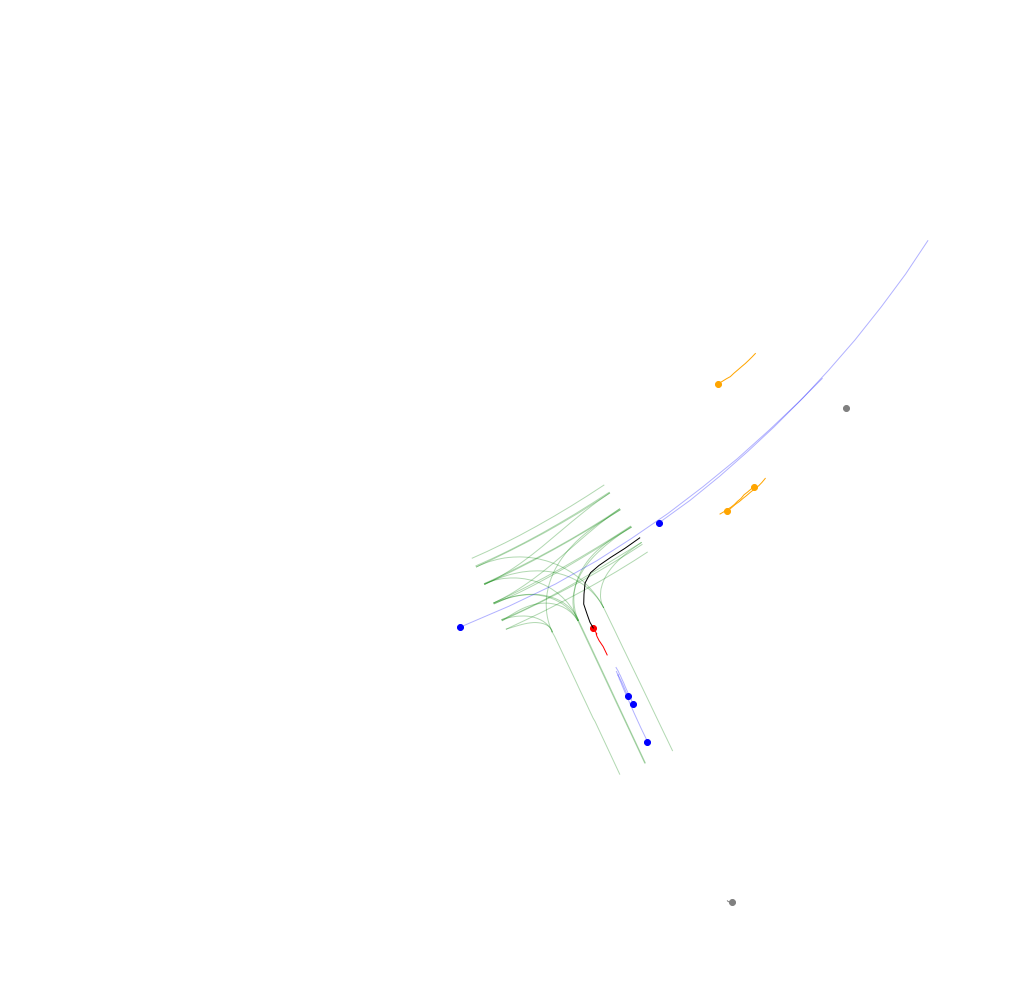

In [431]:
# task= pickle.load(open("/home/lab1/repo/planning/tasks/task.pickle",'rb'))[0]
task = sample['veh'][0]

# plot_action_space('8KfB', lane_list=lane_list, grid_boundary=grid_boundary,task=task)
# plot_action_with_bound('8KfB', lane_list=lane_list, \
#                            grid_boundary=grid_boundary, veh=sample['veh'][1:], ped=sample['ped'], cyc=sample['cyc'],
#                     target_obs=target_obs, planned=target_planned, task=task)

plot_planning_result('8KfB', lane_list=lane_list, \
                           grid_boundary=grid_boundary, veh=sample['veh'][1:], ped=sample['ped'], cyc=sample['cyc'],
                    target_obs=target_obs, planned=target_planned, task=task)

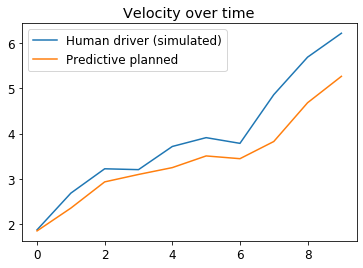

In [434]:
acc_human, v_human = get_aseq(env2.target.traj)
acc_planned, v_planned = get_aseq(np.vstack((target_obs, target_planned[1:])))
# print("acc_human", acc_human)
# print("v_human", v_human)
# print("acc_planned", acc_planned)
# print("v_planned", v_planned)
x = np.arange(len(acc_human))
plt.title("Velocity over time")
plt.plot(np.arange(len(v_human)), v_human, label='Human driver (simulated)')
plt.plot(np.arange(len(v_planned)), v_planned, label= "Predictive planned")
plt.legend()
# plt.savefig('result_fig/acc')
plt.show()

In [433]:
pickle.dump(env2, open("/home/lab1/repo/planning/intergration/paper/new_env_t_slow_for_thru2.pickle",'wb'))